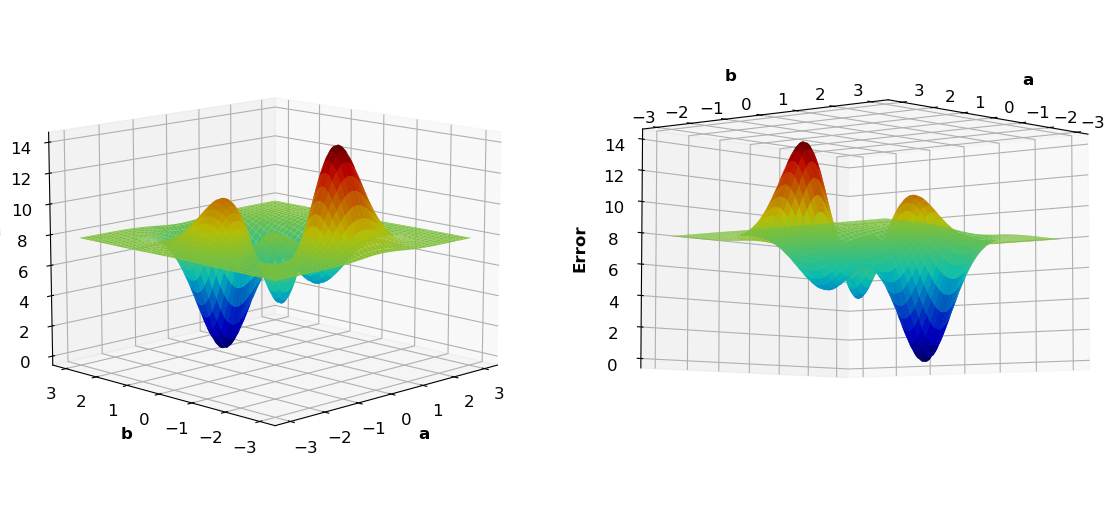

In [1]:
#The code below is adapted from an in-class activity. It is a simple “hill-climbing” algorithm (except that it is descending
#rather than climbing) with the goal of reaching the lowest point on an error surface. Focus only on the optimize and step functions toward 
#the end; the rest of the code contains helper functions to make plots, displayed only for reference. 
# MOST OF THIS CODE IS PROVIDED ONLY FOR REFERENCE, NOT TO BE FOCUSED ON IN THIS ASSIGNMENT. SCROLL DOWN TO THE 'OPTIMIZE' AND 'STEP' FUNCTIONS NEAR THE END.
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
plt.rcParams.update({'font.size': 12})

def error(a, b):
   # defines the function from here https://www.youtube.com/watch?v=1i8muvzZkPw
    func = 3*(1 - a)**2*np.exp(-a**2-(b+1)**2) - 10*(a/5-a**3-b**5)*np.exp(-a**2-b**2) - (1/3)*np.exp(-b**2-(a+1)**2)
    return -func + 7.8

def get_xyz(f, a_limits=(-3, 3), b_limits=(-3, 3)):
    # sets up an xy grid with associated z values for 3d plotting
    a = np.linspace(a_limits[0], a_limits[1], num=100)
    b = np.linspace(b_limits[0], b_limits[1], num=100)

    mesh = np.meshgrid(a, b)
    z = np.vectorize(f)(mesh[0], mesh[1])

    return mesh[0], mesh[1], z

def fmt(x):
    return '{0:.{1}f}'.format(x, 1)

def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

dark_jet = cmap_map(lambda x: x*0.75, matplotlib.cm.jet)

def _plot2d(f, a_limits=(-3, 3), b_limits=(-3, 3), max=(0, 1.6)):
    # creates a 2d contour plot
    a, b, z = get_xyz(f, a_limits, b_limits)
    
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes()

    z = ax.contour(a, b, z, levels=22, cmap=dark_jet)
    ax.clabel(z, inline=True, fontsize=12,  fmt=fmt)

    ax.grid(True)
    ax.grid(True, which="minor", linestyle="dotted")

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))

    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.plot(*max, marker="*", markersize=18)

    return fig, ax

def plot2d(f, a_limits=(-3, 3), b_limits=(-3, 3), max=(0, 1.6)):
    # plots the optimization landscape
    _, ax = _plot2d(f, a_limits, b_limits, max)
    ax.set_xlabel('a',fontweight='bold')
    ax.set_ylabel('b',fontweight='bold')
    plt.show()

def plot3d(f, a_limits=(-3, 3), b_limits=(-3, 3)):
   # same, but plots in 3d with the same colorscheme
    a, b, z = get_xyz(f, a_limits, b_limits)

    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    #ax = plt.axes(projection='3d')
    ax.view_init(12,-135)
    ax.plot_surface(a, b, z, cmap=dark_jet, edgecolor='none')
    ax.set_xlabel('a',fontweight='bold')
    ax.set_ylabel('b',fontweight='bold')
    ax.set_zlabel('Error',fontweight='bold')
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.view_init(-5,40)
    ax.plot_surface(a, b, z, cmap=dark_jet, edgecolor='none')
    ax.set_xlabel('a',fontweight='bold')
    ax.set_ylabel('b',fontweight='bold')
    ax.set_zlabel('Error',fontweight='bold')
    
    plt.show()

def plot_optimization(move, start_a, start_b, stepsize, max_steps=1500):
    # given the starting points, creates a 2d contour plot, and error plot, and prints the end results
    a, b, errors = optimize(move, start_a, start_b, stepsize=stepsize, max_steps=1500)
    
    fig, ax = _plot2d(error)
    ax.plot(a, b, marker='o',  markersize=3, color='gray')
    ax.plot(start_a, start_b, marker='o',  markersize=9, color='green')
    ax.plot(a[-1], b[-1], marker='v',  markersize=9, color='black')
    ax.set_xlabel('a',fontweight='bold')
    ax.set_ylabel('b',fontweight='bold')
    plt.show()
    print("Final location (a,b) =", (round(a[-1],2),round(b[-1],2)))
    print("Final value of Error(a,b) =", round(errors[-1],3))
    
    plt.xlabel('Steps')
    plt.ylabel('Error')
    plt.plot(errors, marker='.')
    plt.show()
    
### THE FUNCTIONS BELOW SHOULD BE THE FOCAL POINT OF YOUR ANALYSIS

def step(a, b, stepsize):
    # how to take a step
    current_error = error(a, b)

    if error(a + stepsize, b) < current_error:
        a = a + stepsize
    elif error(a, b + stepsize) < current_error:
        b = b + stepsize
    elif error(a - stepsize, b) < current_error:
        a = a - stepsize
    elif error(a, b - stepsize) < current_error:
        b = b - stepsize
  
    return a, b

def optimize(move, start_a, start_b, stepsize, max_steps=150):
    # takes defined "move" function, and implements an optimization run
    all_a = [start_a]
    all_b = [start_b]
    all_error = [error(start_a,start_b)]

    for i in range(max_steps):
        a, b = move(start_a, start_b, stepsize)
        
        if a == start_a and b == start_b:
            break
    
        start_a, start_b = a, b

        all_a.append(start_a)
        all_b.append(start_b)
        all_error.append(error(start_a,start_b))

    return all_a, all_b, all_error

plot3d(error)

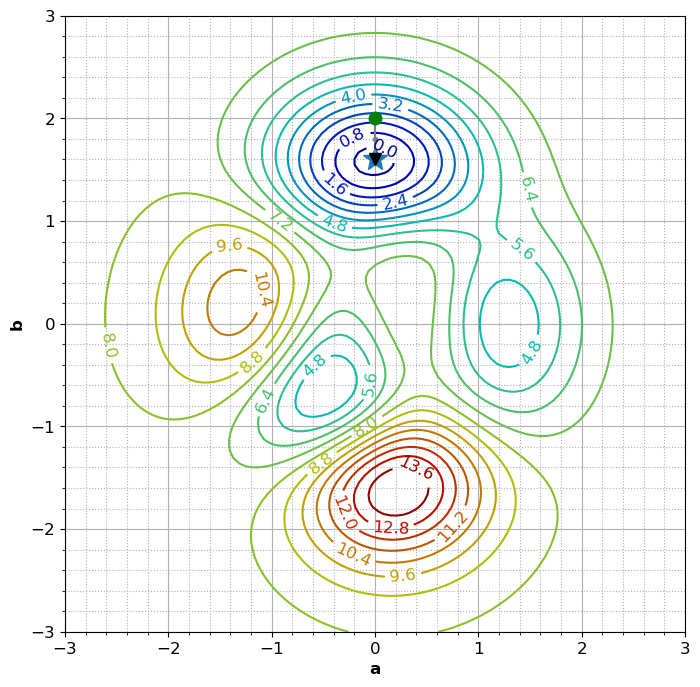

Final location (a,b) = (0, 1.6)
Final value of Error(a,b) = -0.3


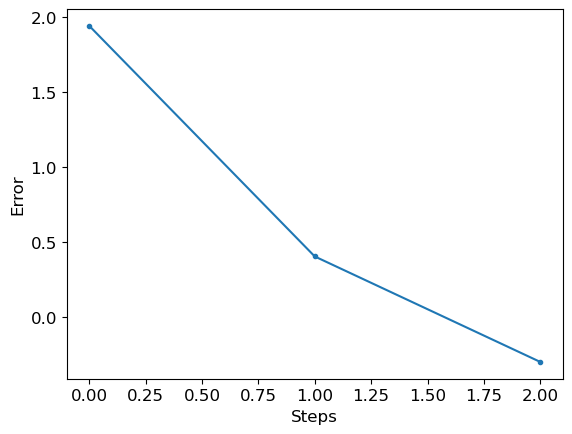

In [2]:
# call the optimization functions and visualize the process
# you can play around with different starting points and step sizes!
START_A = 0
START_B = 2
stepsize = 0.2
plot_optimization(step, START_A, START_B, stepsize)

# uncomment the next line if you want to print the resulting lists for a, b, and Error
#optimize(step, START_A, START_B, stepsize) 

In [3]:
# This is the function where we try to find the best solution for our problem by moving around in our search space.
def optimize(move, start_a, start_b, stepsize, max_steps=150, num_restarts=5):
    # We start with the assumption that we haven't found a good solution yet, so we set the best error very high.
    best_a, best_b, best_error = start_a, start_b, np.inf
    all_paths = []  # This list will keep track of the paths we take for each restart.

    # We will try to find a solution multiple times, this is one of those restarts.
    for restart in range(num_restarts):
        current_path = []  # This will record the steps we take in this particular restart.

        # We pick a random starting point within our search space.
        start_a = np.random.uniform(-3, 3)
        start_b = np.random.uniform(-3, 3)

        # We begin taking steps to find a better solution until we reach the maximum steps allowed.
        for i in range(max_steps):
            # 'move' is a function that takes a step for us and gives us a new position.
            a, b = move(start_a, start_b, stepsize)
            # We calculate the error (how far we are from the best solution) at this new position.
            current_error = error(a, b)
            # We record our current position and the error.
            current_path.append((a, b, current_error))

            # If we haven't moved, it means we can't find a better position right now, so we stop.
            if a == start_a and b == start_b:
                break
            # Update our position to the new one.
            start_a, start_b = a, b

        # We add the path of this restart to our list of paths.
        all_paths.append(current_path)

        # If the last error we found is smaller (better) than any we've seen before, we remember this solution.
        if current_error < best_error:
            best_a, best_b, best_error = start_a, start_b, current_error

    # We print out the best solution we've found and its associated error.
    print(f"Best location before return: (a, b) = ({best_a}, {best_b})")
    print(f"Best error value found: {best_error}")

    # We return the best solution and the paths we took to get there for further analysis.
    return best_a, best_b, best_error, all_paths

# Here we set up how many times we want to restart the search, how big each step should be, and the maximum number of steps.
num_restarts = 20
stepsize = 0.1
max_steps = 150

# We call our optimize function with the settings we just defined and save the best solutions and paths.
best_a, best_b, best_error, all_paths = optimize(step, 0, 0, stepsize, max_steps, num_restarts)

Best location before return: (a, b) = (0.011232148060766584, 1.573165332449757)
Best error value found: -0.3016045816812456


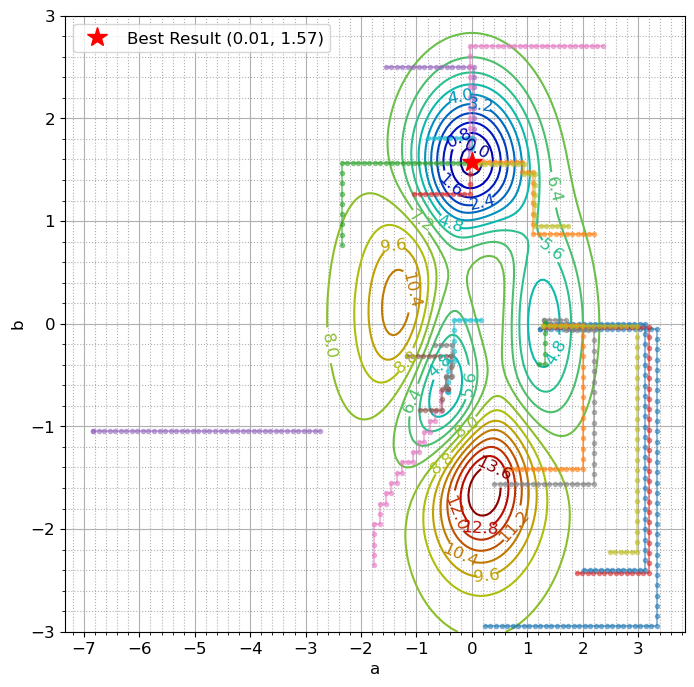

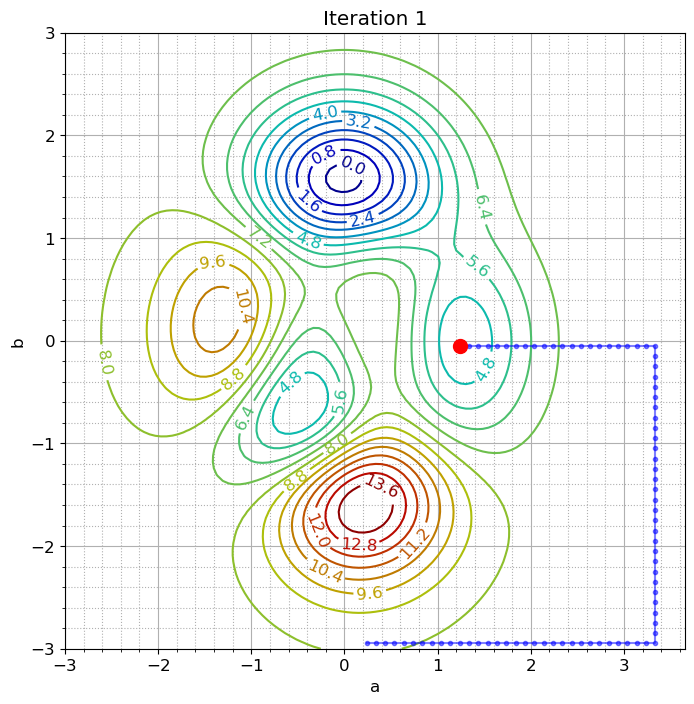

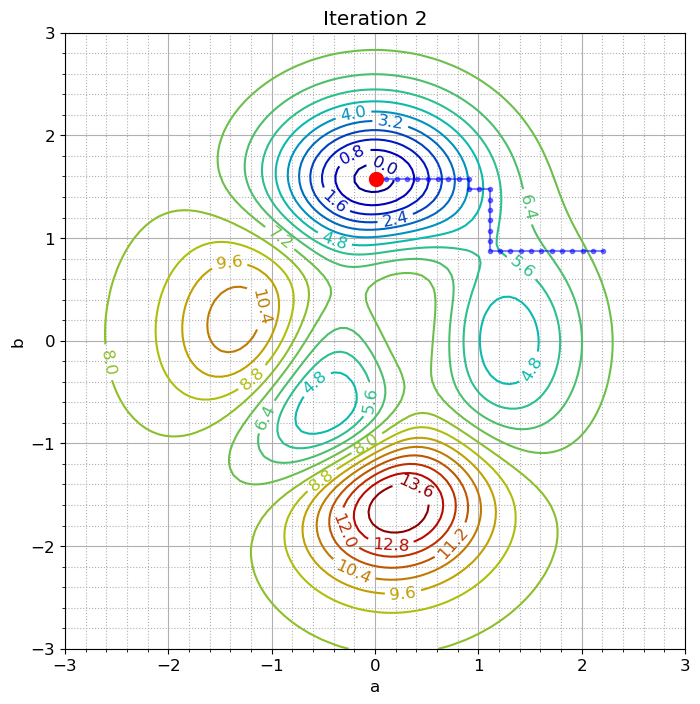

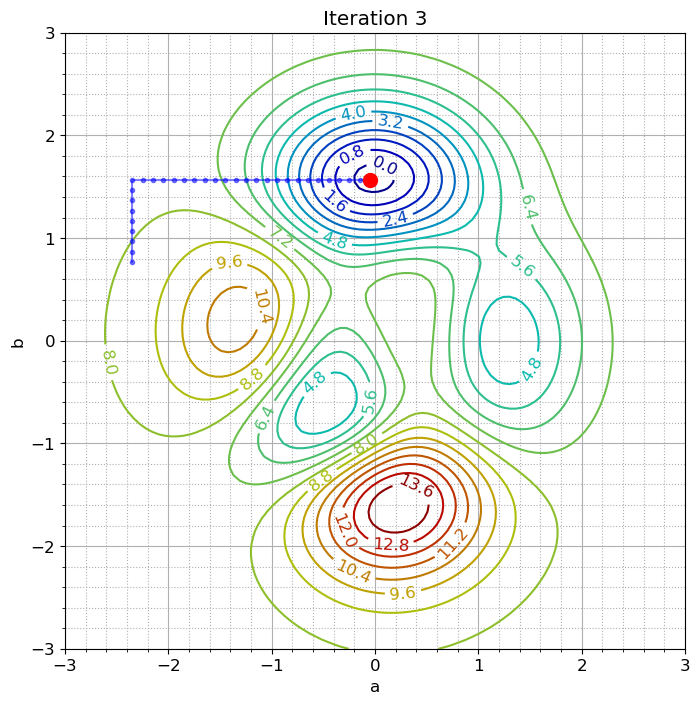

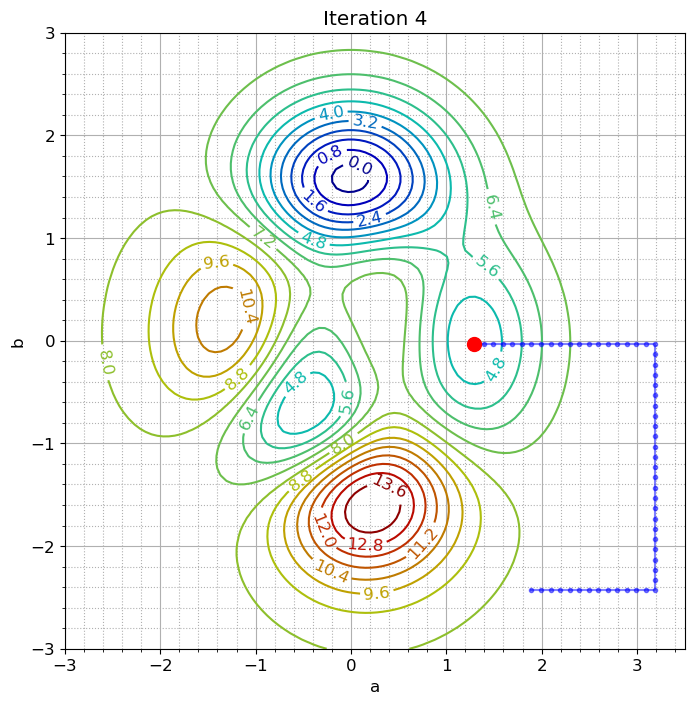

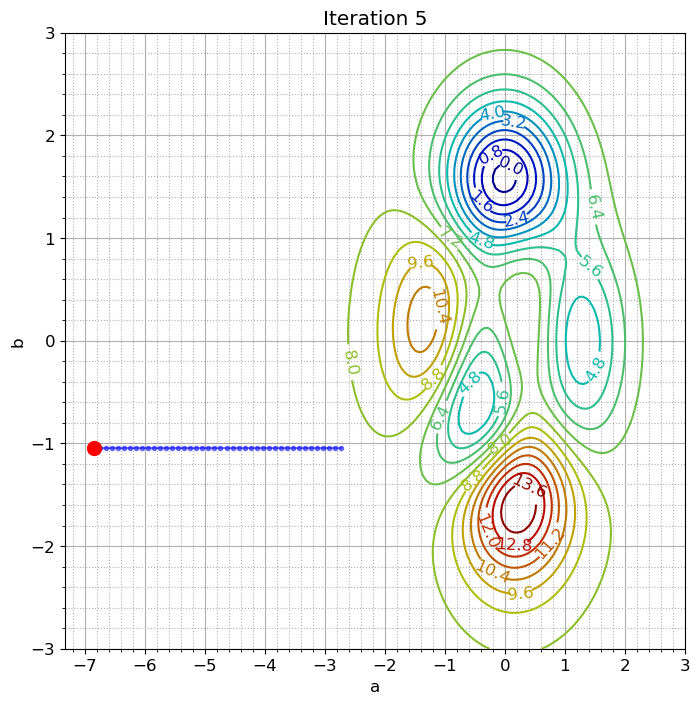

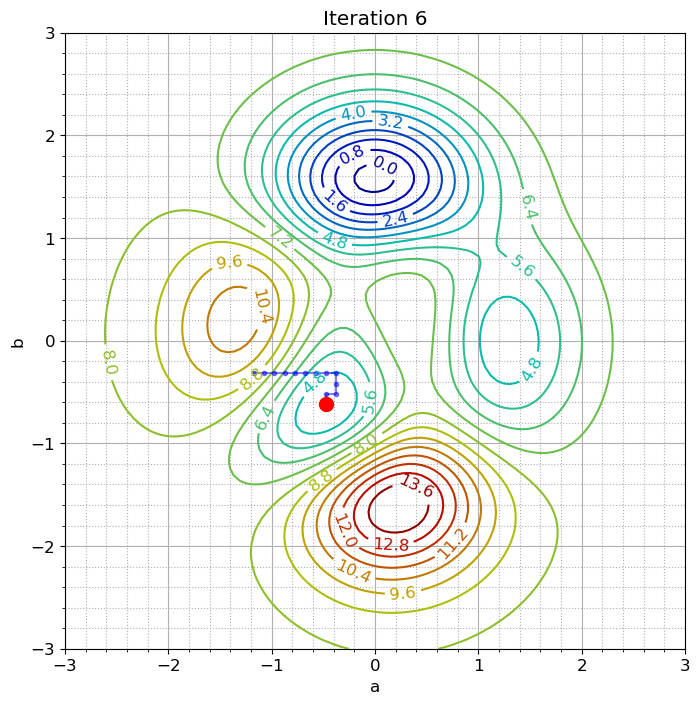

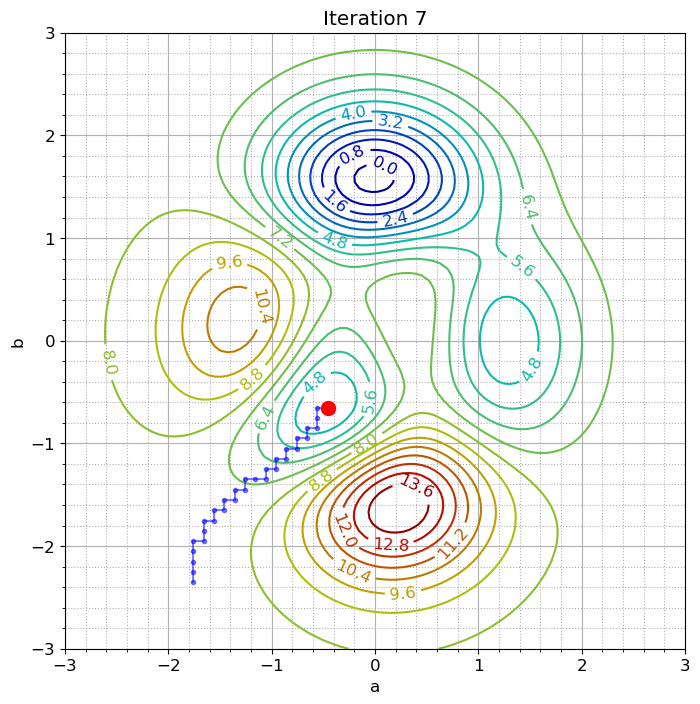

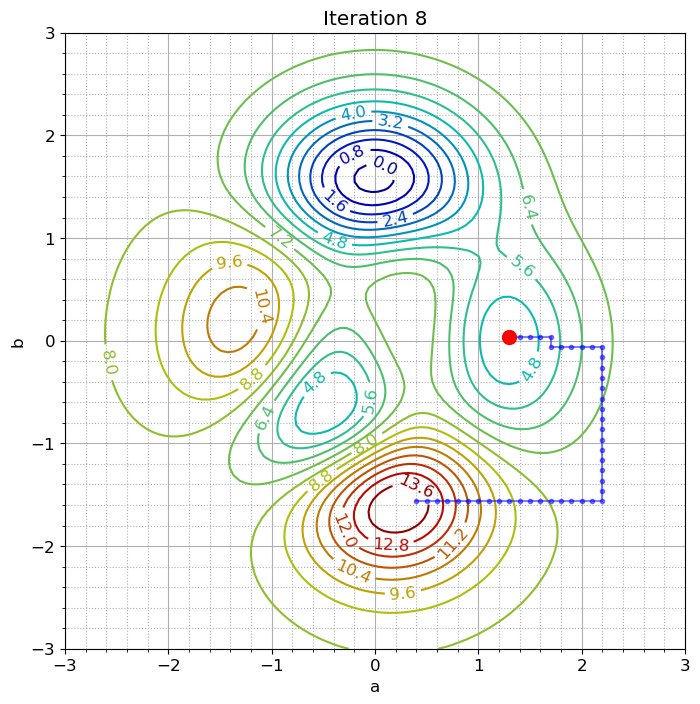

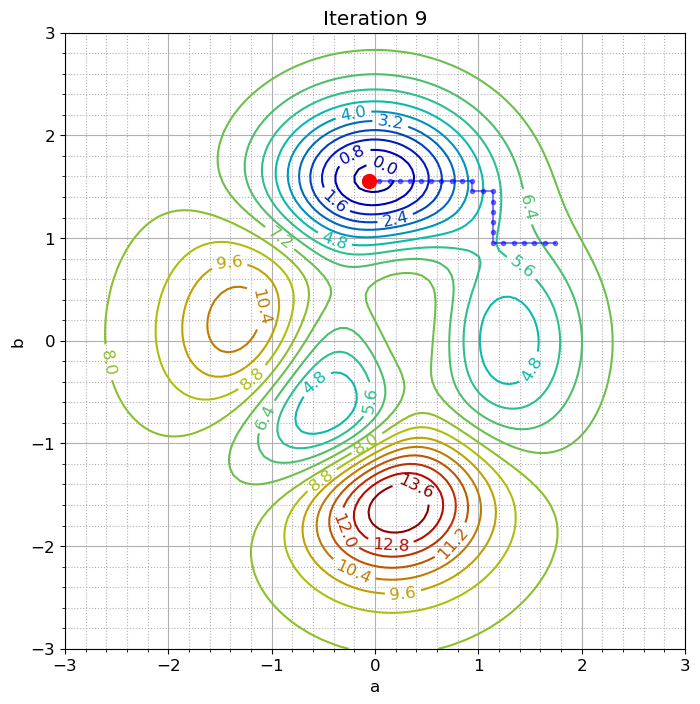

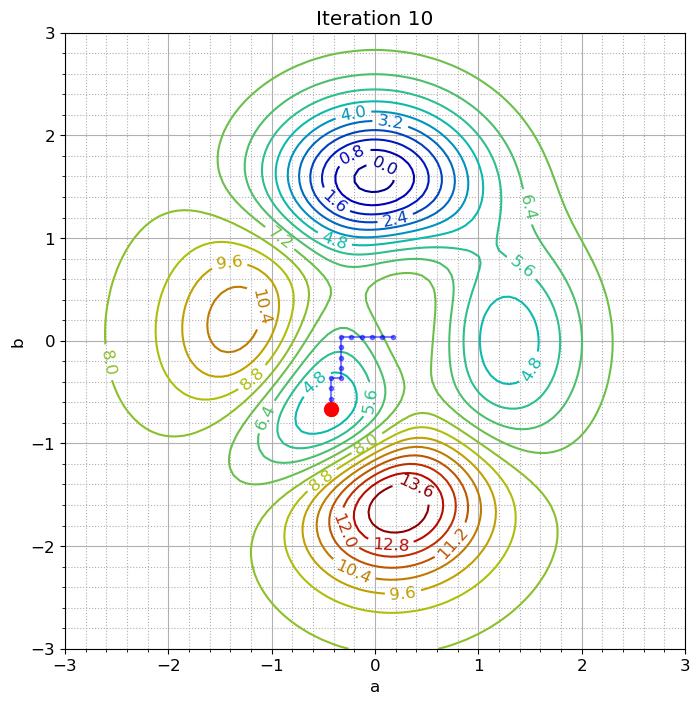

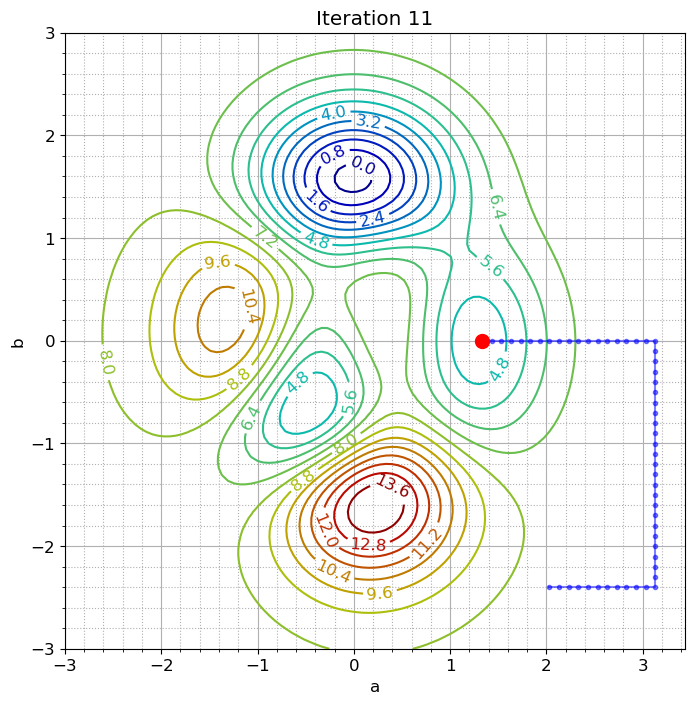

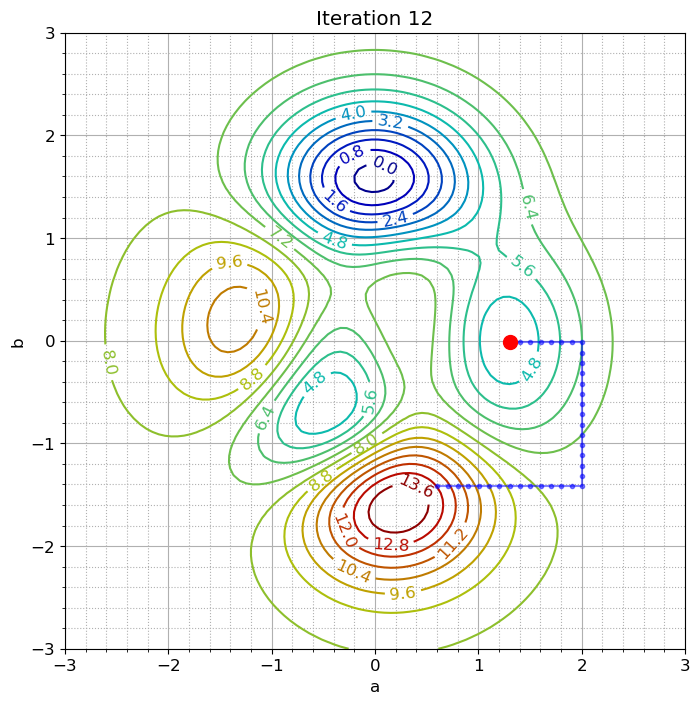

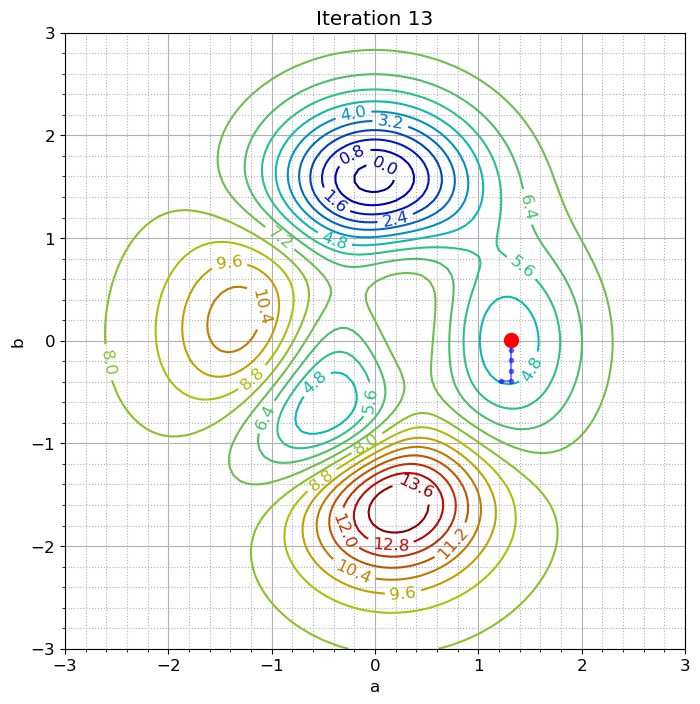

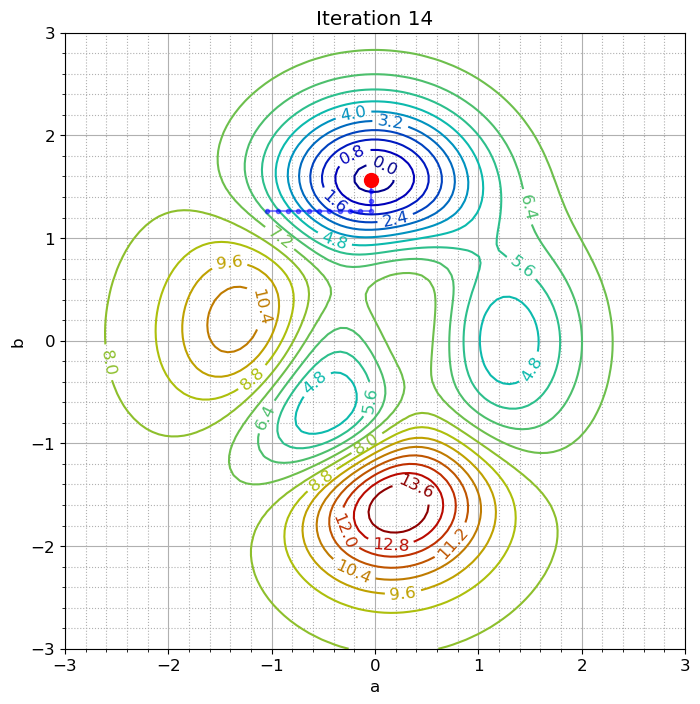

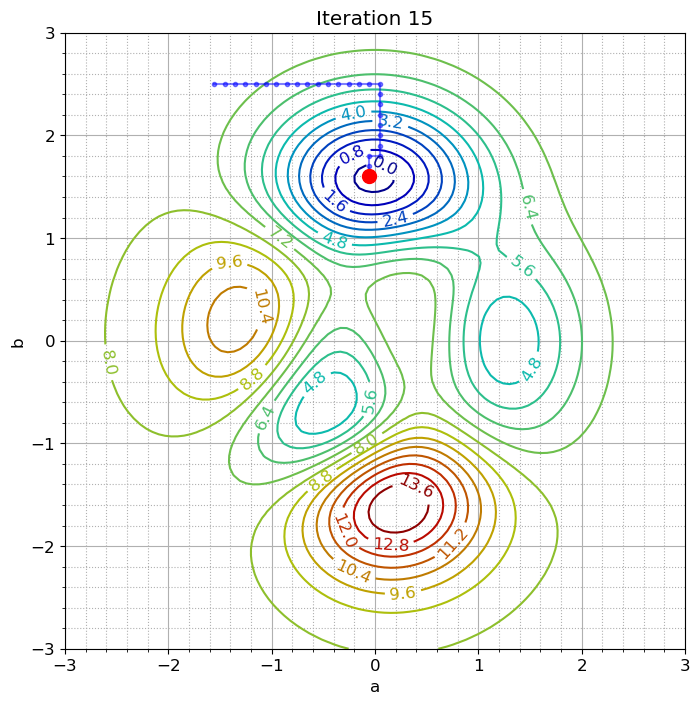

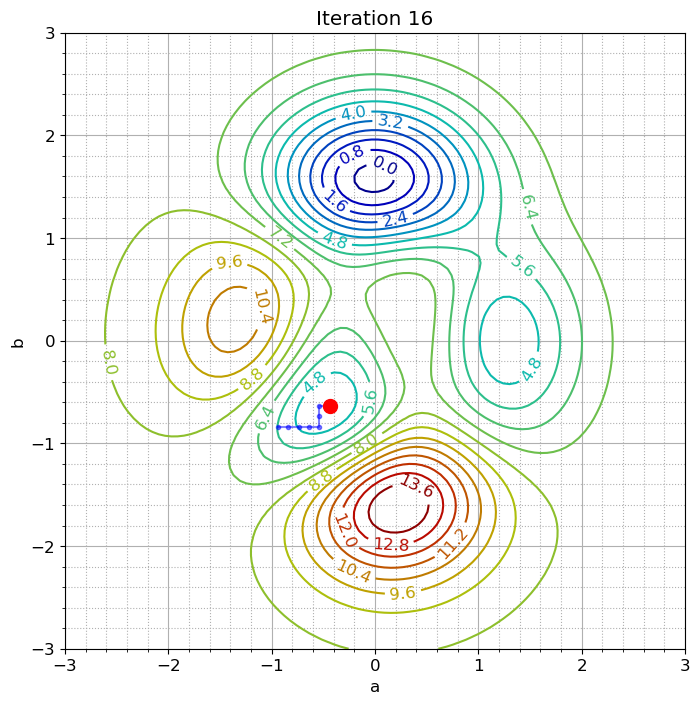

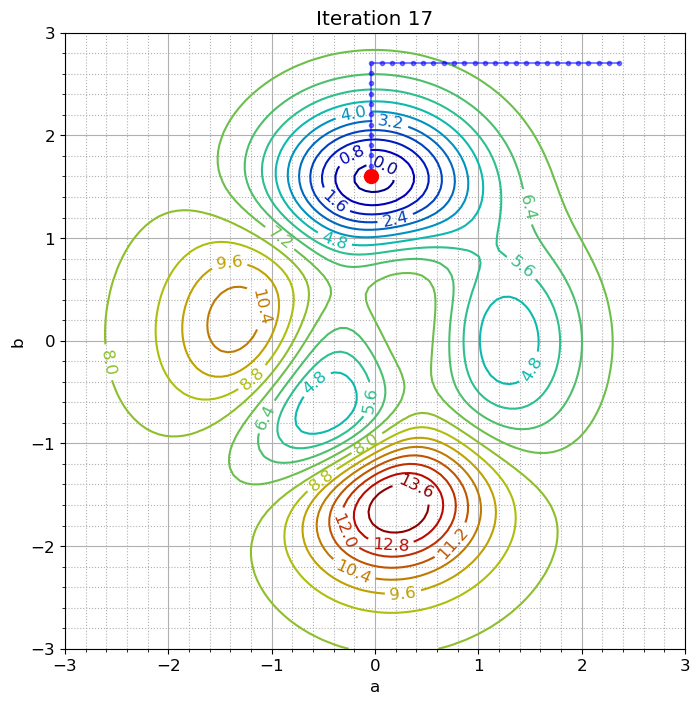

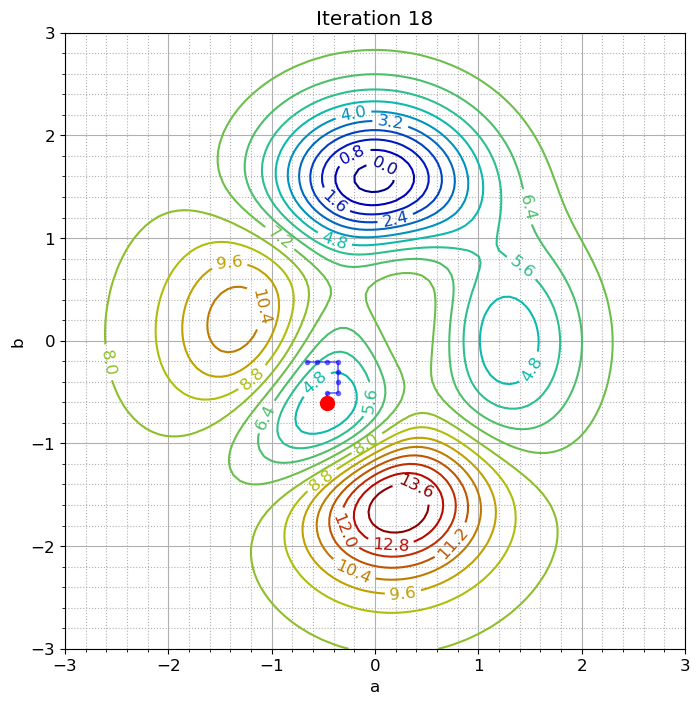

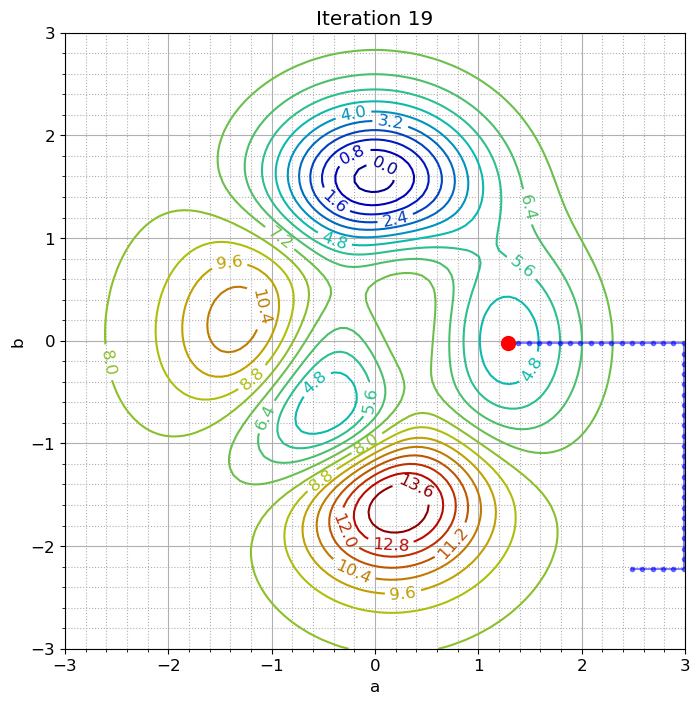

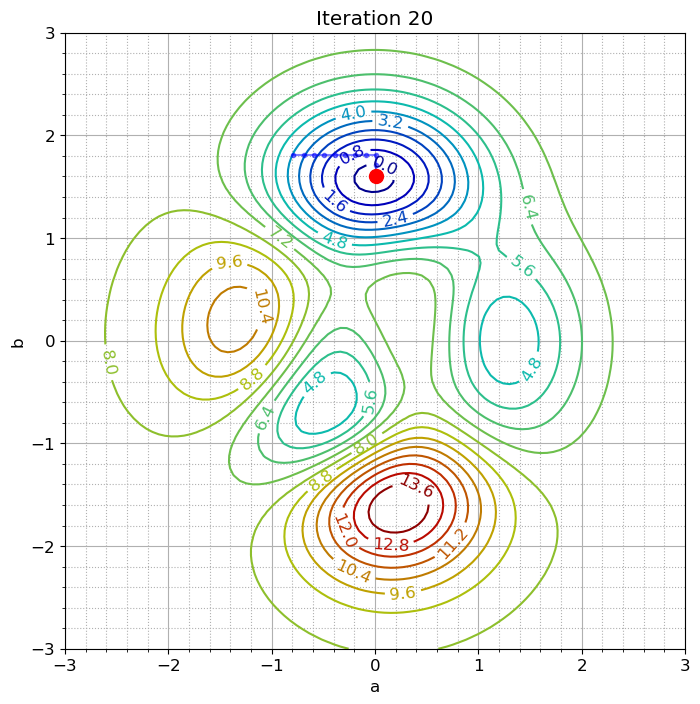

In [4]:
# Visualization
def _plot2d(f, a_limits=(-3, 3), b_limits=(-3, 3)):
    a, b, z = get_xyz(f, a_limits, b_limits)
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes()
    z = ax.contour(a, b, z, levels=22, cmap=dark_jet)
    ax.clabel(z, inline=True, fontsize=12, fmt=fmt)
    ax.grid(True)
    ax.grid(True, which="minor", linestyle="dotted")
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    return fig, ax
# After defining the plotting function, we draw the paths each set of (a, b) took during optimization.
fig, ax = _plot2d(error)  # Ensure this matches your function's definition

# Plot the paths from all restarts
for path in all_paths:
    a_vals, b_vals, _ = zip(*path)  # Unpack a, b, and error from each path
    ax.plot(a_vals, b_vals, marker='.', linestyle='-', alpha=0.5)

# Highlight the best result
ax.plot(best_a, best_b, 'r*', markersize=15, label=f'Best Result ({best_a:.2f}, {best_b:.2f})')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.legend()
plt.show()


#creating one visualization with all the plots
def plot_single_path(path, iteration_number, best_a, best_b):
    fig, ax = _plot2d(error)
    a_vals, b_vals, _ = zip(*path)  # Unpack a, b, and error from the path
    ax.plot(a_vals, b_vals, marker='.', linestyle='-', color='blue', alpha=0.5)
    ax.plot(a_vals[-1], b_vals[-1], 'ro', markersize=10)  # Last point in this path
    ax.set_title(f'Iteration {iteration_number}')
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    plt.show()
    plt.close(fig)

# Loop through each path and create a separate plot
for i, path in enumerate(all_paths):
    plot_single_path(path, i+1, best_a, best_b)

In [5]:
##CHANGED THE ERROR FUNCTION TO HAVE A NEW LANDSCAPE TO CHECK IF THE ALGORITHM WOULD WORK   

    def error(a, b):
   # defines the function, taking the original values and changing a little bit to modify the landscape error
    func = 2 * (np.abs(1 - a)**2) * np.exp(-(a**2) - (b+1.5)**2) \
           - 10 * (a/3 - a**2 - b**4) * np.exp(-a**2 - b**2) \
           - (1/2) * np.exp(-(b**2) - (a+1)**2)    
    return -func + 6

# This function tries to find the lowest point on our error surface (the global minimum).
def optimize(move, start_a, start_b, stepsize, max_steps=150, num_restarts=5):
    # We start with very high error values as placeholders for the best results we find.
    best_a, best_b, best_error = start_a, start_b, np.inf
    all_paths = []  # To collect paths from all restarts
    for restart in range(num_restarts):
        current_path = []  # To store the path for the current restart
        start_a = np.random.uniform(-3, 3)
        start_b = np.random.uniform(-3, 3)
        for i in range(max_steps):
            # We make a move based on our current location and step size.
            a, b = move(start_a, start_b, stepsize)
            # We calculate the error at the new location.
            current_error = error(a, b)
            # Store current position and error
            current_path.append((a, b, current_error))
            # If we haven't moved, it means we can't find a better solution in this direction, so we break the loop.
            if a == start_a and b == start_b:
                break  # No improvement, so break the loop
            # Update the current position
            start_a, start_b = a, b
        # After finishing this run, we store the path we took.
        all_paths.append(current_path)
        #Check if the final error of the current run is the best so far.
        if current_error < best_error:
            best_a, best_b, best_error = start_a, start_b, current_error
    # We print the best location and its error value we found after all restarts.
    print(f"Best location before return: (a, b) = ({best_a}, {best_b})")
    print(f"Best error value found: {best_error}")

    # Finally, we return the best results and all paths for potential visualization.
    return best_a, best_b, best_error, all_paths

num_restarts = 50
stepsize = 0.1
max_steps = 150
# We call the optimization function with these parameters.
best_a, best_b, best_error, all_paths = optimize(step, 0, 0, stepsize, max_steps, num_restarts)

# Visualization
def _plot2d(f, a_limits=(-3, 3), b_limits=(-3, 3)):
    a, b, z = get_xyz(f, a_limits, b_limits)
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes()
    z = ax.contour(a, b, z, levels=22, cmap=dark_jet)
    ax.clabel(z, inline=True, fontsize=12, fmt=fmt)
    ax.grid(True)
    ax.grid(True, which="minor", linestyle="dotted")
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    return fig, ax

fig, ax = _plot2d(error)

# Plot the paths from all restarts
for path in all_paths:
    #Unpack a, b, and error from each path.
    a_vals, b_vals, _ = zip(*path) 
    ax.plot(a_vals, b_vals, marker='.', linestyle='-', alpha=0.5)

#Highlight the best result
ax.plot(best_a, best_b, 'r*', markersize=15, label=f'Best Result ({best_a:.2f}, {best_b:.2f})')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.legend()
plt.show()

IndentationError: unexpected indent (989417427.py, line 3)

In [ ]:
#Optional challenge: Write your own algorithm in Python to solve the same optimization problem. 
#I decided to do a genetic algorithm. This method effectively solves complex optimization problems,
#such as those with many local optima or big search space. 

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

# This function creates a 2D contour plot of our error landscape (updated from the first code cell).
def _plot2d(f, population, a_limits=(-3, 3), b_limits=(-3, 3)):
    a, b, z = get_xyz(f, a_limits, b_limits)
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes()
    
    # Plot contour lines on the axes where each line represents a level of error.
    cp = ax.contour(a, b, z, levels=22, cmap='viridis')
    ax.clabel(cp, inline=True, fontsize=10)
    
    # Scatter plot the current population on top of the contour plot to show their positions.
    pop_a = [individual[0] for individual in population]
    pop_b = [individual[1] for individual in population]
    ax.scatter(pop_a, pop_b, color='red', zorder=5) 
    
    # Add a grid to the plot for better readability, and set major and minor locators for tick marks.
    ax.grid(True)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    
    # Label the axes.
    ax.set_xlabel('a', fontweight='bold')
    ax.set_ylabel('b', fontweight='bold')
    ax.set_xlim(a_limits)
    ax.set_ylim(b_limits)
    
    return fig, ax

def get_xyz(f, a_limits, b_limits):
    # Generate a sequence of 'a' values from the lower to upper limit, evenly spaced, creating 100 points.
    a = np.linspace(a_limits[0], a_limits[1], 100)
    # Generate a sequence of 'b' values in the same way as 'a'.
    b = np.linspace(b_limits[0], b_limits[1], 100)
    A, B = np.meshgrid(a, b)
    # Calculate the 'z' values using the function 'f' for all combinations of 'a' and 'b'.
    Z = f(A, B) 
    return A, B, Z

# Define the error function which represents the landscape we want to optimize. I took the same function as the original in code cell 1.
def error(a, b):
    func = 3*(1 - a)**2*np.exp(-a**2 - (b+1)**2) - 10*(a/5 - a**3 - b**5)*np.exp(-a**2 - b**2) - (1/3)*np.exp(-(b**2) - (a+1)**2)
    return -func + 7.8

# A function to initialize our population with random 'a' and 'b' values within the given limits.
def initialize_population(population_size, a_limits, b_limits):
    return [[np.random.uniform(a_limits[0], a_limits[1]), np.random.uniform(b_limits[0], b_limits[1])] for _ in range(population_size)]

# Evaluate the fitness of the population (assuming lower error is better).
def evaluate_population(population):
    return [-error(individual[0], individual[1]) for individual in population]

def select_parents(population, fitness, num_parents):
    # Find the minimum fitness value.
    min_fitness = min(fitness) 
    # Shift fitness by subtracting min_fitness and adding 1 to ensure positivity.
    adjusted_fitness = [f - min_fitness + 1 for f in fitness]  
    # Calculate the sum of all adjusted fitness values to normalize probabilities later.
    fitness_sum = sum(adjusted_fitness)
    # Create a list of selection probabilities for each individual in the population.
    probabilities = [f / fitness_sum for f in adjusted_fitness]
    # Randomly select parent indices based on the calculated probabilities.
    parents_indices = np.random.choice(len(population), size=num_parents, p=probabilities, replace=False)
    return [population[i] for i in parents_indices]

# Crossover to produce offspring
def crossover(parent1, parent2):
    # 'alpha' is a blending parameter that determines how much genetic information is taken from each parent. Here, we set it to 0.5,       which means we take an equal mix from both parents.
    alpha = 0.5
    # We create two new children. Each gene (parameter 'a' or 'b') of the child is an average of the parents' genes.
    # For example, if parent1's 'a' is 2 and parent2's 'a' is 4, child1's 'a' will be 3 (the average).
    child1 = [alpha * parent1[i] + (1 - alpha) * parent2[i] for i in range(len(parent1))]
    child2 = [alpha * parent2[i] + (1 - alpha) * parent1[i] for i in range(len(parent1))]
    # The function returns two new individuals (children) which are a mix of both parents.
    return [child1, child2]

# Mutate an individual by randomly changing their a or b value
def mutate(individual, mutation_rate, a_limits, b_limits):
    # Check if mutation should occur based on the mutation rate.
    if np.random.rand() < mutation_rate:
        # Randomly decide which gene to mutate: 'a' or 'b', with an equal chance.
        if np.random.rand() < 0.5:
            # Mutate 'a' by assigning a new random value within its limits.
            individual[0] = np.random.uniform(a_limits[0], a_limits[1])
        else: 
            # Mutate 'b' in the same way as 'a'.
            individual[1] = np.random.uniform(b_limits[0], b_limits[1])
    # Return the potentially mutated individual.
    return individual

# Genetic algorithm main loop
def genetic_algorithm(population_size, a_limits, b_limits, generations, mutation_rate):
    # Initialize a population of individuals with random 'a' and 'b' values within specified limits.
    population = initialize_population(population_size, a_limits, b_limits)
    # Set the best fitness to the lowest possible value as a starting point.
    best_fitness = float('-inf')
    # Initialize variables to hold the best solution found and its fitness evolution over generations.
    best_solution = None
    best_fitness_evolution = []
    
    # Loop through each generation of the algorithm.
    for generation in range(generations):
        # Evaluate the fitness of the current population.
        fitness = evaluate_population(population)
        # Find the highest fitness in the current population.
        current_best_fitness = max(fitness)
        # If the current best fitness is better than the overall best, update the best records.
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_solution = population[np.argmax(fitness)]
        # Record the best fitness of this generation.
        best_fitness_evolution.append(-best_fitness)
        fig, ax = _plot2d(error, population, a_limits, b_limits)
        plt.show()
        
        # Selecting half of the population as parents based on their fitness.
        parent_solutions = select_parents(population, fitness, population_size // 2)
        # Initialize an empty list to store offspring.
        offspring = []
        # Continue generating offspring until we reach the desired population size.
        while len(offspring) < (population_size - len(parent_solutions)):
            # Randomly select two parents without replacement to ensure diversity.
            parent_indices = np.random.choice(len(parent_solutions), 2, replace=False)
            # Retrieve the actual parent solutions from the indices.
            parent1, parent2 = parent_solutions[parent_indices[0]], parent_solutions[parent_indices[1]]
            # Generate two children through the crossover function and add them to the offspring list.
            offspring.extend(crossover(parent1, parent2))
        # Ensure the offspring list does not exceed the population size when combined with parent solutions
        offspring = offspring[:population_size - len(parent_solutions)]
        # Mutate the offspring to introduce new genetic variations.
        mutated_offspring = [mutate(child, mutation_rate, a_limits, b_limits) for child in offspring]
        # The new population for the next generation consists of the parent solutions and the mutated offspring.
        population = parent_solutions + mutated_offspring
    # Return the best solution found, its fitness, and the evolution of the best fitness over generations.
    return best_solution, -best_fitness, best_fitness_evolution

# Plotting functions
def plot_error_surface():
    a = np.linspace(-3, 3, 100)
    b = np.linspace(-3, 3, 100)
    A, B = np.meshgrid(a, b)
    # Calculate the error for each combination of 'a' and 'b' to visualize the error surface.
    Z = np.array([error(ai, bi) for ai, bi in zip(np.ravel(A), np.ravel(B))])
    # Reshape the error values to match the grid shape for plotting.
    Z = Z.reshape(A.shape)
    
    # Create a 3D plot to visualize the error surface.
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    # Plot the surface using a colormap to indicate error magnitude.
    surf = ax.plot_surface(A, B, Z, cmap='viridis', alpha=0.8)
    # Add a color bar to help interpret the error magnitude visually.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    # Set the view to be more horizontal (make it better)
    ax.view_init(elev=13, azim=-50)
    # Labeling the axes to clarify what each dimension represents.
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.set_zlabel('Error')
    ax.set_title('Error Surface')
    return fig, ax

def visualize_population(population, ax):
    # Extracting 'a', 'b', and their corresponding error values from the population for plotting.
    xs = [ind[0] for ind in population]
    ys = [ind[1] for ind in population]
    zs = [error(ind[0], ind[1]) for ind in population]
    # Plotting the current population on the error surface as red dots.
    ax.scatter(xs, ys, zs, color='r')

def plot_fitness_evolution(best_fitness_evolution):
    # Creating a line plot to show how the best fitness evolves over generations.
    plt.figure(figsize=(10, 6))
    plt.plot(best_fitness_evolution, marker='o', linestyle='-', color='b')
    plt.title('Best Fitness Evolution Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness (Negative Error)')
    plt.grid(True)
    plt.show()
    
population_size = 200
generations = 20
mutation_rate = 0.05
a_limits = (-3, 3)
b_limits = (-3, 3)
best_solution, best_solution_fitness, best_fitness_evolution = genetic_algorithm(population_size, a_limits, b_limits, generations, mutation_rate)

print(f"Best solution: {best_solution}")
print(f"Best solution fitness (lowest error): {best_solution_fitness}")

# Plotting the error surface and population
fig, ax = plot_error_surface()
visualize_population(initialize_population(population_size, a_limits, b_limits), ax)
plt.show()

# Plotting the fitness evolution
plot_fitness_evolution(best_fitness_evolution)

In [ ]:
##THIS IS THE SAME CODE AS ABOVE, BUT FOR THE TESTING I CHANGED THE ERROR FUNCTION TO CREATE A NEW LANDSCAPE, TO CHECK THE GENERALIZABILTIY

# Define the error function which represents the landscape we want to optimize. I changed the code cell 1 function to create a new landscape, to test the algorithm.
def error(a, b):
    func = 2 * (np.abs(1 - a)**2) * np.exp(-(a**2) - (b+1.5)**2) \
           - 10 * (a/3 - a**2 - b**4) * np.exp(-a**2 - b**2) \
           - (1/2) * np.exp(-(b**2) - (a+1)**2)    
    return -func + 6

best_solution, best_solution_fitness, best_fitness_evolution = genetic_algorithm(population_size, a_limits, b_limits, generations, mutation_rate)

print(f"Best solution: {best_solution}")
print(f"Best solution fitness (lowest error): {best_solution_fitness}")

# Plotting the error surface and population
fig, ax = plot_error_surface()
visualize_population(initialize_population(population_size, a_limits, b_limits), ax)
plt.show()

# Plotting the fitness evolution
plot_fitness_evolution(best_fitness_evolution)